In [2]:
# %load object_established_coslice_simulator.py
from common import *
from TINT_rule import *
from graph_show import *
from data_load import *
from TINT_config import *
from TINT_recoder import *
from my_function import *

import networkx as nx
import matplotlib.pyplot as plt
import itertools as iter
import random
import pandas as pd
import numpy as np
from tqdm import tqdm,trange

#得られた関手を解釈しやすいAにとってのCはBにとってのDという形で標準出力に表示する
def show_metaphar(F_edge_dict,target_A,target_B):
    for base,target in F_edge_dict.items():
        b_dom,b_cod = base
        t_dom,t_cod = target
        # prob = est_A[t_dom][t_cod]["weight"]
        # print(b_dom,"にとっての",b_cod,"は",t_dom,"にとっての",t_cod,"：",prob)
        print("{0:<5} にとっての {1:<5}\t {2:<5} にとっての {3:<5}".format(b_dom,b_cod,t_dom,t_cod))

#得られた関手を解釈しやすいAにとってのCはBにとってのDという形でファイルに書き出す
def save_metaphar(fname,F_edge_dict,target_A,target_B):
    with open(save_dir+fname,'w') as f:
        tsv_writer = csv.reader(f, delimiter="\t")
        for base,target in F_edge_dict.items():
            b_dom,b_cod = base
            t_dom,t_cod = target
            if b_dom == b_cod and t_dom==t_cod:
                continue
            tsv_writer.writerows("{0:<5} にとっての {1:<5}\t {2:<5} にとっての {3:<5}\n".format(b_dom,b_cod,t_dom,t_cod))

#喩辞と被喩辞の意味を表す圏の間での射の対応を探索する
def categories_nt_search(g, T, S, est_T, est_S, cutoff):
    if len(list(est_T.nodes())) == 0:
        print("コスライス圏Aのノード数が０")
    if len(list(est_S.nodes())) == 0:
        print("コスライス圏Bのノード数が０")

    #B->Bはfork ruleのやらない、B->Aの射は想定してない
    S_succs = np.array([cod for cod in est_S.successors(S) if cod != S and cod != T])#Bから出ている対象で恒等射とAは省く
    T_succs = np.array([cod for cod in est_T.successors(T) if cod != T])#Aから出ている対象で恒等射は省く

    #いま現状は痩せた圏なので集合型でいい
    fork_edges = set()  #自然変換
    T_rem_edges = set() #Aで残る射
    S_rem_edges = set() #Bで残る射
    BMF_node_dict = {S:T}
    F_node_dict = {S:T}

    #ネストを深くしたくなかったので、numpy配列のブーリアンインデックスで
    #全ての自然変換の候補が励起するかどうかを全ての喩辞の対象について一気に判断する
    #TODO：np.ix_をうまく使えれば最後のforもいらなくなりそう

    #自然変換の探索で使う全ての重みを取得  #確率を取る部分を変えれば合成射まで探すことも可能
    nt_weight_mat = np.array([[g[s_node][t_node]["weight"] for t_node in T_succs] for s_node in S_succs])
    #重みと同じ形状のランダム値が入った配列を生成
    rnd_mat = np.random.rand(len(S_succs),len(T_succs))
    for i, (rnd_list, nt_weight_list) in enumerate(zip(rnd_mat, nt_weight_mat)):
        nt_cand_list = T_succs[rnd_list < nt_weight_list]                   #自然変換の候補の取得
        if nt_cand_list.size == 0:#候補が一つも励起されなかった場合飛ばす
            continue
        nt_cand_weights = nt_weight_list[rnd_list < nt_weight_list]         #候補の部分の重みを取得
        nt_idx_list = np.where(nt_cand_weights == np.max(nt_cand_weights))  #最大の重みのリストを取得
        nt_idx = random.choice(nt_idx_list[0])                              #最大のものが複数あったときにはランダムで
        S_node, T_node = S_succs[i] , nt_cand_list[nt_idx]
        BMF_node_dict[S_node] = S_node  #BMFの記録
        F_node_dict[S_node] = T_node    #Fの記録
        fork_edges.add((S_node, T_node))    #自然変換の要素を記録
        T_rem_edges.add((T,T_node))         #Fでうつされる射を記録
        S_rem_edges.add((S,S_node))         #BMF,Fのうつり元となる射を記録
    return fork_edges, T_rem_edges, S_rem_edges, BMF_node_dict, F_node_dict

#喩辞・被喩辞のコスライス圏の両方が確立している場合のシミュレーション関数
def TINT_simu_est(g, A, B, est_A, est_B, config, recoder):
    sim_times = config.sim_times
    anti_time = config.anti_time
    anti_type = config.anti_type
    seed = config.seed
    fork_cutoff = 1
    nt_cutoff = config.nt_cutoff
    is_show = config.is_show
    is_save = config.is_save
    neigh_limit = config.neigh_limit
    A_name_dict = config.A_name_dict
    B_name_dict = config.B_name_dict

    BMF_is_functor, F_is_functor = False, False
    if is_show: # 圏の初期状態を表示
        show_graphs([est_A,est_B],["shell","shell"],True,False,["sim start A\C","sim start B\C"])

    #est_Aとest_Bの対応付け探索する
    fork_edges, A_rem_edges, B_rem_edges, BMF_node_dict, F_node_dict = categories_nt_search(g, A, B, est_A, est_B,nt_cutoff)

    #対応を取るときはAがBにfでつながった形にしなければいけない。それでは元に戻せないので現状の圏を保管しておく
    tmp_estB = est_B
    tmp_fork,tmp_A,tmp_B = fork_edges, A_rem_edges, B_rem_edges


    # 対応がつかなかった部分をanti-fork ruleで削除する
    if anti_type == "forced":
        est_A,est_B,A_rem_edges,B_rem_edges = forced_anti_fork_rule(est_A,est_B,A,B,fork_edges,A_rem_edges,B_rem_edges,F_node_dict)
    elif anti_type == "non_identity":
        est_A,est_B,A_rem_edges,B_rem_edges = non_indentity_forced_anti_fork_rule(est_A,est_B,A,B,fork_edges,A_rem_edges,B_rem_edges,F_node_dict)
    elif anti_type == "full":
        est_A,est_B = full_anti_fork_rule(est_A,est_B,A,fork_edges,A_rem_edges,B_rem_edges)

    if is_show: # anti-fork ruleで緩和された後の圏を表示
        show_nt_graph(est_A,est_B,A,B,fork_edges,A_rem_edges,B_rem_edges,["sim A\C metaphar","sim B\C"])

    #もしAnti-fork ruleですべてのノードがなくなってしまった場合飛ばす
    if len(list(est_A.nodes())) == 0 or len(list(est_B.nodes())) == 0:
        print("Anti-fork ruleで全てのノードがなくなってしまった")
        return

    # BMFが関手かどうかをチェック
    BMF_edge_dict = edge_correspondence_dict(est_B,est_A,BMF_node_dict)
    if BMF_edge_dict != None:
        BMF_is_functor = functor(est_B,est_A,BMF_node_dict,BMF_edge_dict)

    # Fが関手かどうかをチェック
    F_edge_dict = edge_correspondence_dict(est_B,est_A,F_node_dict)
    if F_edge_dict != None:
        F_is_functor = functor(est_B,est_A,F_node_dict,F_edge_dict)

    if BMF_is_functor == False or F_is_functor == False:
        print("Fが関手にならなかった")
        return

    # 自然変換をなしているかどうかを判定
    metaphar = natural_transfomation(est_B,est_A,BMF_node_dict,BMF_edge_dict,F_node_dict,F_edge_dict)
    if metaphar == None:
        print("自然変換にならなかった")
        return

    #ここでコスライス圏に戻す
    cos_A = coslice_category(est_A,A)
    identity_morphism(cos_A)

    cos_B = coslice_category(est_B,B)
    identity_morphism(cos_B)

    if is_show:
        # show_metaphar(F_edge_dict,A,B)
        pass

    # 関手Fでの対象と射の対応を辞書形で記憶する
    recoder.recode_functor_F(A,B,1,F_edge_dict)

    # 以下表示、記録用

    #コスライス圏Bからコスライス圏AにFでうつされる部分の圏を作る（表示用）
    F_est_A = nx.DiGraph()
    for dom,cod in F_edge_dict.values():
        F_est_A.add_edge(dom,cod)

    if is_show or is_save:
        # 関手で対応付けられた対象と射を分かりやすいように、名前の後に対応番号を付ける
        n_A,n_B = cor_label_graph(F_est_A, est_B, F_node_dict, F_edge_dict)

        # 通常の圏での関手をコスライス圏での関手に変換する
        cos_F_node_dict,cos_F_edge_dict = coslice_functor(A, B, F_edge_dict)

        # コスライス圏の対象の名前を(A,B)から(A→B)に変換する
        new_cos_A,node_name_dict_A,edge_name_dict_A = modify_coslice_node_name(cos_A)
        new_cos_B,node_name_dict_B,edge_name_dict_B = modify_coslice_node_name(cos_B)

        # コスライス圏での関手を（A->B）に変更したので、関手の辞書も変更する
        new_node_dict,new_edge_dict = modify_coslice_functor_name(cos_F_node_dict,cos_F_edge_dict,
                                        node_name_dict_A,edge_name_dict_A,
                                        node_name_dict_B,edge_name_dict_B)

        # コスライス圏も同様に対応番号を付けた形の新しい圏を作る
        cos_n_A,cos_n_B = cor_label_graph(new_cos_A, new_cos_B, new_node_dict, new_edge_dict)
        identity_morphism(cos_n_A)
        identity_morphism(cos_n_B)

    if is_show: #Fによって移された部分に対応番号を付けたものを表示
        show_graphs([n_A,n_B],["shell","shell"],True,True,["sim  A\C F","sim  B\C F"])

    if is_save:#圏の画像を保存する
        header = config.data_header if isinstance(config, Three_metaphor_TINT_config) else ""
        # まずそれぞれの圏を画像として保存する
        save_graphs([n_A,n_B],
            ["EST_"+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F",
            "EST_"+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F"],
            ["circo","circo"])
        # コスライス圏の状態にしたものも同様に保存する
        save_graphs([cos_n_A,cos_n_B],
            ["EST_"+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F_cos",
            "EST_"+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F_cos"],
            ["origin","origin"])

        # それぞれの圏の画像を横に結合する
        img1 = [IMAGE_DIR+"EST_"+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F.png",1]
        img2 = [IMAGE_DIR+"EST_"+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F.png",1]
        filepath = IMAGE_DIR+"EST_"+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_"+B_name_dict[B]+"_F.png"
        image_hcombine(img1,img2,filepath,False)
        recoder.recode_image_file_name_recode(A, B, filepath)

        # コスライス圏も同様に画像を横に結合する
        img1 = [IMAGE_DIR+"EST_"+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F_cos.png",1]
        img2 = [IMAGE_DIR+"EST_"+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F_cos.png",1]
        filepath = IMAGE_DIR+"EST_"+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_"+B_name_dict[B]+"_F_cos.png"
        image_hcombine(img1,img2,filepath,False)
        recoder.recode_cos_image_file_name_recode(A, B, filepath)

    if is_show: # そのステップでの最終的な結果を表示する
        show_graphs([est_A,est_B],["shell","shell"],True,False,["sim A\C result","sim B\C result"])

#3つの比喩についてTINTのシミュレーションを実行する関数
#def established_three_metaphor_sim(w2v_seed, A, B):
def established_three_metaphor_sim(A, B):    

    #全てのイメージのデータを取得する
#    node_data = get_node_data(w2v_seed)
    node_data = get_node_data()
    A_targets ,B_targets, A_fname, B_fname = get_A_B_targets(A,B)


    A_name_dict = {key:value for key,value in zip(A_targets,A_fname)} #喩辞のファイル名（記録用）
    B_name_dict = {key:value for key,value in zip(B_targets,B_fname)} #被喩辞のファイル名（記録用）
    sim_iter = 1000                     # シミュレーション回数
    sim_times = 1                       # 圏を発展させるステップ数
    anti_time = 1                       # anti-fork ruleを掛けるタイミング（何ステップごとに掛けるか）
    nt_step = 1                         # 自然変換を探索する際に何ステップで行ける系をまでを見るか
    is_show = False                     # シミュレーション中に圏を表示するか
    is_save = False                     # シミュレーションの結果を画像として保存するか
    anti_type = "full"                  # anti-fork ruleの種類(full,forced)
    seed = 6000                         # ランダムシード
    data_index = "all"                  # 4人のデータを使ったので、記録する際にどのデータを使ったのかのヘッダー(0~3,all)

    # 連想強度データから潜在圏を作る
    assoc_net = make_assoc_net("source","target")
    #シード値でのループ
    for seed_inc in trange(0,1,desc="SEED_LOOP",leave=False):
        random.seed(seed+seed_inc)
        np.random.seed(seed=seed+seed_inc)

        recoder = Three_metaphor_TINT_recoder(A_targets,B_targets,sim_iter,sim_times,anti_time,anti_type,data_index,seed+seed_inc)
        #比喩でのループ
        for target_A,target_B in zip(tqdm(A_targets,desc="HIYU LOOP",leave=False),B_targets):
            A_nodes = None
            config = Three_metaphor_TINT_config(sim_times,anti_time,anti_type,seed+seed_inc,A_nodes,nt_step,is_show,is_save,A_name_dict,B_name_dict,data_index)

            #コスライス圏Aの対象だけを確立させる（A->?）の射だけ
            #ここでコサイン類似度でsortした中から上位8単語だけを抽出してコスライス圏を作る    
            est_A = nx.DiGraph()            
            A_node_data = node_data[node_data[0]==target_A]
            for cod in A_node_data[1]:
                #恒等射は抜く
                if target_A == cod or not assoc_net.has_edge(target_A,cod):
                    continue
                est_A.add_edge(target_A,cod)
            #こっちで恒等射を作る
            identity_morphism(est_A)

            #コスライス圏Bの対象だけを確立させる(B->?)の射だけ
            est_B = nx.DiGraph()
            B_node_data = node_data[node_data[0]==target_B]
            for cod in B_node_data[1]:
                if target_B == cod or not assoc_net.has_edge(target_B,cod):
                        continue
                est_B.add_edge(target_B,cod)
            identity_morphism(est_B)

            #シミュレーション回数でのループ
            for i in trange(sim_iter,desc="SIM_LOOP",leave=False):
                #実際のシミュレーションを行う関数を呼び出す
                TINT_simu_est(assoc_net, target_A, target_B, est_A, est_B, config, recoder)

        # recodeに記録されている関手Fをすべてファイルに吐き出す
        recoder.all_dict_to_csv(True,True)


if __name__ == "__main__":
    A = "butterfly"
    B = "dancer"
    established_three_metaphor_sim(A,B)


HIYU LOOP:   0%|          | 0/1 [00:00<?, ?it/s]

SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]

SIM_LOOP:   1%|          | 12/1000 [00:00<00:08, 113.94it/s]

SIM_LOOP:   2%|▎         | 25/1000 [00:00<00:08, 116.54it/s]

SIM_LOOP:   4%|▎         | 37/1000 [00:00<00:08, 116.15it/s]

SIM_LOOP:   5%|▍         | 48/1000 [00:00<00:08, 110.84it/s]

SIM_LOOP:   6%|▌         | 59/1000 [00:00<00:08, 109.84it/s]

SIM_LOOP:   7%|▋         | 73/1000 [00:00<00:07, 116.79it/s]

SIM_LOOP:   8%|▊         | 85/1000 [00:00<00:07, 116.71it/s]

SIM_LOOP:  10%|▉         | 99/1000 [00:00<00:07, 122.63it/s]

SIM_LOOP:  11%|█         | 112/1000 [00:00<00:07, 119.93it/s]

SIM_LOOP:  12%|█▏        | 124/1000 [00:01<00:07, 115.51it/s]

SIM_LOOP:  14%|█▎        | 136/1000 [00:01<00:07, 110.04it/s]

SIM_LOOP:  15%|█▍        | 149/1000 [00:01<00:07, 114.41it/s]

SIM_LOOP:  16%|█▌        | 162/1000 [00:01<00:07, 116.94it/s]

SIM_LOOP:  17%|█▋        | 174/1000 [00:01<00:07, 112.36it/s]

SIM_LOOP:  19%|█▊       

In [4]:
# %load tri_established_coslice_simulator.py
from common import *
from TINT_rule import *
from graph_show import *
from data_load import *
from TINT_config import *
from TINT_recoder import *
from my_function import *

import networkx as nx
import matplotlib.pyplot as plt
import itertools as iter
import random
import pandas as pd
import numpy as np
from tqdm import tqdm,trange

import sys
import pprint

#def make_all_triangle_edge_correspondence_csv(target,source,seed,w2v_seed):
def make_all_triangle_edge_correspondence_csv(target,source,seed):
    Corr_DIR = "./tri_edge_correspondence/"
    node_data = get_node_data()

    B_node_data = sort_cossim_data(source)
    B_init_nodes = list(B_node_data[1])
    B_init_nodes.remove(source)
    B_remain_image = [[dom,cod] for dom,cod in iter.permutations(B_init_nodes, 2)]

    matrix = []
    tri_matrix = []
    for B_remain_tri in B_remain_image:
        tri_dom,tri_cod = B_remain_tri
        df_edge_corr = pd.read_csv(Corr_DIR+"FOREDGE_Date_all_seed_6000_{}_{}_{}_{}_forced_anti_1_iter_1000_correspondence.tsv".format(target,source,tri_dom,tri_cod),header=0,encoding="utf-8", sep="\t")

        df_edge_corr = df_edge_corr.fillna("NA")                    #列にNAを追加
        A_node_data = sort_cossim_cod_data(target)   #被喩辞のイメージをとる
        B_node_data = B_remain_tri                                  #被喩辞三角構造のイメージをとる


        # 対象同士の対応づけについてカウントする
        edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}
        for B_node in B_node_data:
            corr_A_nodes = df_edge_corr[(df_edge_corr["B_cod"]==B_node) & (df_edge_corr["B_dom"] == source)]
            for corr_A in corr_A_nodes.itertuples(): #一行ずつ取り出し
                count = corr_A.count
                edge_corr_dict[(B_node,corr_A.A_cod)] = count

        # コスライス圏の射の対応についてカウントする
        tri_corr_dict = {((tri_dom,tri_cod),(A_dom,A_cod)):0 for A_dom,A_cod in iter.permutations(A_node_data, 2)}
        tri_corr_dict[((tri_dom,tri_cod),("NA","NA"))] = 0
        #Bのデータが現在考えているコスライス圏の射となっているデータを取り出す
        df_tri_corr = df_edge_corr[(df_edge_corr["B_dom"]==tri_dom) & (df_edge_corr["B_cod"] == tri_cod)]
        for corr_A in df_tri_corr.itertuples():
            count = corr_A.count
            tri_corr_dict[((tri_dom,tri_cod),(corr_A.A_dom,corr_A.A_cod))] = count

        for B_node in B_node_data:
            row = [(tri_dom,tri_cod),B_node]
            for A_node in A_node_data+["NA"]:
                row.append(edge_corr_dict[(B_node,A_node)])
            matrix.append(row)

        tri_matrix.append(list(tri_corr_dict.values()))

    df = pd.DataFrame(matrix,columns=["tri_edge","dom/cod"]+A_node_data+["NA"])
    file_name = Corr_DIR+"seed_{}_{}_{}_all_triangle_correspondence.tsv".format(seed,target,source)
    df.to_csv(file_name, sep="\t")

#得られた関手を解釈しやすいAにとってのDはBにとってのCという形で標準出力に表示する
def show_metaphar(F_edge_dict):
    for base,target in F_edge_dict.items():
        b_dom,b_cod = base
        t_dom,t_cod = target
        print("{0:<5} にとっての {1:<5}\t {2:<5} にとっての {3:<5}".format(b_dom,b_cod,t_dom,t_cod))

#得られた関手を解釈しやすいAにとってのDはBにとってのCという形でファイルに書き出す
def save_metaphar(fname,F_edge_dict,target_A,target_B):
    with open(save_dir+fname,'w') as f:
        for base,target in F_edge_dict.items():
            b_dom,b_cod = base
            t_dom,t_cod = target
            if b_dom == b_cod and t_dom==t_cod:
                continue
            f.write("{0:<5} にとっての {1:<5}\t {2:<5} にとっての {3:<5}\n".format(b_dom,b_cod,t_dom,t_cod))

# 自然変換の候補のうち、構造が最も類似しているもの(対応づけられた射の廉造確率の差の総和が最小なもの)を返す
def similar_structure(g, est_T, T, S, dom, cod, dom_nt_cand_list, cod_nt_cand_list):
    edge_correct_nt_pair = []
    for dom_nt in dom_nt_cand_list:
        for cod_nt in cod_nt_cand_list:
            #関手が成り立つような射が間にない場合飛ばす
            if not est_T.has_edge(dom_nt,cod_nt):
                continue
            if dom_nt == cod_nt: #現状は埋め込みが起こるような部分を省いて探す
                continue
            dom_edge_weight   = g[S][dom]["weight"]
            cod_edge_weight   = g[S][cod]["weight"]
            cos_edge_weight   = g[dom][cod]["weight"]
            F_dom_edge_weight = g[T][dom_nt]["weight"]
            F_cod_edge_weight = g[T][cod_nt]["weight"]
            F_cos_edge_weight = g[dom_nt][cod_nt]["weight"]

            # ソースの三角構造とターゲットの三角構造の構成要素同士の重みの比較
            # 似た連想確率を持つ構造が一番移り先として適当なのではという予想
            weight_dist = abs(dom_edge_weight-F_dom_edge_weight) + abs(cod_edge_weight-F_cod_edge_weight) + abs(cos_edge_weight-F_cos_edge_weight)
            edge_correct_nt_pair.append((dom_nt,cod_nt,weight_dist))
    if len(edge_correct_nt_pair) == 0:
        return None
    # 差分が最小のものを返す
    return min(edge_correct_nt_pair,key=lambda x:x[-1])

# 自然変換の候補のうち、自然変換のペアとその間の射の連想確率が最大のものを返す
def max_mean_structure(g, est_T, T, S, dom, cod, dom_nt_cand_list, cod_nt_cand_list):
    edge_correct_nt_pair = []
    # 三角構造の3つの射の連想確率の平均
    for dom_nt in dom_nt_cand_list:
        for cod_nt in cod_nt_cand_list:
            #関手が成り立つような射が間にない場合飛ばす
            if not est_T.has_edge(dom_nt,cod_nt):
                continue
            if dom_nt == cod_nt: #現状は埋め込みが起こるような部分を省いて探す
                continue
            doms_weight = g[dom][dom_nt]["weight"]
            cods_weight = g[cod][cod_nt]["weight"]
            nt_weight   = g[dom_nt][cod_nt]["weight"]
            weight_mean = (doms_weight + cods_weight + nt_weight) / 3
            edge_correct_nt_pair.append((dom_nt,cod_nt,weight_mean))
    # 差分が最小のものを返す
    if len(edge_correct_nt_pair) == 0:
        return None
    return max(edge_correct_nt_pair,key=lambda x:x[-1])

#コスライス圏の射を一度に対応付けられるように喩辞と被喩辞の圏の間での対応を探索する
def categories_nt_search_for_edge(g, T, S, est_T, est_S, cutoff):
    if len(list(est_T.nodes())) == 0:
        print("コスライス圏Aのノード数が０")
    if len(list(est_S.nodes())) == 0:
        print("コスライス圏Bのノード数が０")
    #B->Bはfork ruleのやらない、B->Aの射は想定してない
    S_succs = np.array([cod for cod in est_S.successors(S) if cod != S and cod != T])#Bから出ている対象で恒等射とAは省く
    T_succs = np.array([cod for cod in est_T.successors(T) if cod != T])#Aから出ている対象で恒等射は省く

    S_cos_edge = [edge  for edge in est_S.edges if edge[0] != S and edge[0] != edge[1]] # ソースのコスライス圏の射を取る

    #いま現状は痩せた圏なので集合型でいい
    fork_edges = set()  #自然変換
    T_rem_edges = set() #Aで残る射
    S_rem_edges = set() #Bで残る射
    BMF_node_dict = {S:T}
    F_node_dict = {S:T}

    #自然変換の探索で使う全ての重みを取得  #確率を取る部分を変えれば合成射まで探すことも可能
    #S_succsの対象からT_succsへの対象の重みの配列を作成
    nt_weight_mat = np.array([[g[s_node][t_node]["weight"] for t_node in T_succs] for s_node in S_succs])
    #重みと同じ形状のランダム値が入った配列を生成
    rnd_mat = np.random.rand(len(S_succs),len(T_succs))

    # コスライス圏の射ごとに対応付けを行う
    # 現状喩辞はに1つの三角構造しか存在しないので、コスライス圏の射のdom,codに対して探している（繰り返し自体は全てのコスライス圏の射を繰り返している）
    for dom,cod in S_cos_edge:
        # コスライス圏の射のdom,codのインデックスを取得
        dom_idx = np.where(S_succs == dom)[0][0]
        cod_idx = np.where(S_succs == cod)[0][0]

        dom_rnd_list  = rnd_mat[dom_idx]        # domから被喩辞の対象へ連想するかどうかを決定するランダム値
        dom_nt_weight = nt_weight_mat[dom_idx]  # domから被喩辞の対象へ連想するかどうかの連想確率
        cod_rnd_list  = rnd_mat[cod_idx]        # comから被喩辞の対象へ連想するかどうかを決定するランダム値
        cod_nt_weight = nt_weight_mat[cod_idx]  # codから被喩辞の対象へ連想するかどうかの連想確率

        # dom,codについて自然変換の要素の候補をとってくる
        dom_nt_cand_list = T_succs[dom_rnd_list < dom_nt_weight]    # dom_rnd_listのなかでdom_nt_weight未満の要素を取得（同じインデックスの要素同士で比較）
        cod_nt_cand_list = T_succs[cod_rnd_list < cod_nt_weight]    # cod_rnd_listのなかでcod_nt_weight未満の要素を取得（同じインデックスの要素同士で比較）

        # 候補の中から最も構造が類似しているものを自然変換の要素として選択
        # 選択する関数の中で、正しく関手になっていない候補は省かれる
        nt_tuple = similar_structure(g,est_T,T,S,dom,cod,dom_nt_cand_list,cod_nt_cand_list)

        # 候補が存在しない場合はそのコスライス圏の射に対応づくものはないとして飛ばす（記録しない）
        if nt_tuple == None:
            continue

        dom_nt,cod_nt,weight = nt_tuple

        # BMFの記録
        BMF_node_dict[dom] = dom
        BMF_node_dict[cod] = cod
        # Fの記録
        F_node_dict[dom] = dom_nt
        F_node_dict[cod] = cod_nt
        # 自然変換の要素になる射を記録
        fork_edges.add((dom,dom_nt))
        fork_edges.add((cod,cod_nt))

        # ターゲット側で残る射を記録
        T_rem_edges.add((T,dom_nt))
        T_rem_edges.add((T,cod_nt))
        T_rem_edges.add((dom_nt,cod_nt))
        T_rem_edges.add((dom,cod))          # BMFでのコスライス圏の射

        # ソース側で残る射を記録
        S_rem_edges.add((S,dom))
        S_rem_edges.add((S,cod))
        S_rem_edges.add((dom,cod))

    return fork_edges, T_rem_edges, S_rem_edges, BMF_node_dict, F_node_dict


#喩辞・被喩辞のコスライス圏の両方が確立している場合のシミュレーション関数
def TINT_simu_est(g, A, B, est_A, est_B, config, recoder):
    sim_times = config.sim_times
    anti_time = config.anti_time
    anti_type = config.anti_type
    seed = config.seed
    fork_cutoff = 1
    nt_cutoff = config.nt_cutoff
    is_show = config.is_show
    is_save = config.is_save
    neigh_limit = config.neigh_limit
    A_name_dict = config.A_name_dict
    B_name_dict = config.B_name_dict

    BMF_is_functor, F_is_functor = False, False
    if is_show: # 圏の初期状態を表示
        show_graphs([est_A,est_B],["shell","shell"],True,False,["sim start A\C","sim start B\C"])

    #est_Aとest_Bの対応付け探索する
    fork_edges, A_rem_edges, B_rem_edges, BMF_node_dict, F_node_dict = categories_nt_search_for_edge(g, A, B, est_A, est_B,nt_cutoff)

    #対応を取るときはAがBにfでつながった形にしなければいけない。それでは元に戻せないので現状の圏を保管しておく
    tmp_estB = est_B
    tmp_fork,tmp_A,tmp_B = fork_edges, A_rem_edges, B_rem_edges

    # 対応がつかなかった部分をanti-fork ruleで削除する
    if anti_type == "forced":
        est_A,est_B,A_rem_edges,B_rem_edges = forced_anti_fork_rule(est_A,est_B,A,B,fork_edges,A_rem_edges,B_rem_edges,F_node_dict)
    elif anti_type == "non_identity":
        est_A,est_B,A_rem_edges,B_rem_edges = non_indentity_forced_anti_fork_rule(est_A,est_B,A,B,fork_edges,A_rem_edges,B_rem_edges,F_node_dict)
    elif anti_type == "full":
        est_A,est_B = full_anti_fork_rule(est_A,est_B,A,fork_edges,A_rem_edges,B_rem_edges)

    if is_show: # anti-fork ruleで緩和された後の圏を表示
        show_nt_graph(est_A,est_B,A,B,fork_edges,A_rem_edges,B_rem_edges,["sim A\C metaphar","sim B\C"])

    #もしAnti-fork ruleですべてのノードがなくなってしまった場合飛ばす
    if len(list(est_A.nodes())) == 0 or len(list(est_B.nodes())) == 0:
        print("Anti-fork ruleで全てのノードがなくなってしまった")
        return

    # BMFが関手かどうかをチェック
    BMF_edge_dict = edge_correspondence_dict(est_B,est_A,BMF_node_dict)
    if BMF_edge_dict != None:
        BMF_is_functor = functor(est_B,est_A,BMF_node_dict,BMF_edge_dict)

    # Fが関手かどうかをチェック
    F_edge_dict = edge_correspondence_dict(est_B,est_A,F_node_dict)
    if F_edge_dict != None:
        F_is_functor = functor(est_B,est_A,F_node_dict,F_edge_dict)

    # どちらかが関手になっていない場合にはシミュレーション終了
    if BMF_is_functor == False or F_is_functor == False:
        print("Fが関手にならなかった")
        return

    # 自然変換をなしているかどうかを判定
    metaphar = natural_transfomation(est_B,est_A,BMF_node_dict,BMF_edge_dict,F_node_dict,F_edge_dict)
    if metaphar == None:
        print("自然変換にならなかった")
        return

    #ここでコスライス圏に戻す
    cos_A = coslice_category(est_A,A)
    identity_morphism(cos_A)

    cos_B = coslice_category(est_B,B)
    identity_morphism(cos_B)

    if is_show:
        # show_metaphar(F_edge_dict)
        pass

    # 関手Fでの対象と射の対応を辞書形で記憶する
    recoder.recode_functor_F(A,B,1,F_edge_dict)

    # 以下表示、記録用
    # コスライス圏Bからコスライス圏AにFでうつされる部分の圏を作る（表示用）
    F_est_A = nx.DiGraph()
    for dom,cod in F_edge_dict.values():
        F_est_A.add_edge(dom,cod)

    if is_show or is_save:
        # 関手で対応付けられた対象と射を分かりやすいように、名前の後に対応番号を付ける
        n_A,n_B = cor_label_graph(F_est_A, est_B, F_node_dict, F_edge_dict)

        # 通常の圏での関手をコスライス圏での関手に変換する
        cos_F_node_dict,cos_F_edge_dict = coslice_functor(A, B, F_edge_dict)

        # コスライス圏の対象の名前を(A,B)から(A→B)に変換する
        new_cos_A,node_name_dict_A,edge_name_dict_A = modify_coslice_node_name(cos_A)
        new_cos_B,node_name_dict_B,edge_name_dict_B = modify_coslice_node_name(cos_B)

        # コスライス圏での関手を（A->B）に変更したので、関手の辞書も変更する
        new_node_dict,new_edge_dict = modify_coslice_functor_name(cos_F_node_dict,cos_F_edge_dict,
                                        node_name_dict_A,edge_name_dict_A,
                                        node_name_dict_B,edge_name_dict_B)

        # コスライス圏も同様に対応番号を付けた形の新しい圏を作る
        cos_n_A,cos_n_B = cor_label_graph(new_cos_A, new_cos_B, new_node_dict, new_edge_dict)
        identity_morphism(cos_n_A)
        identity_morphism(cos_n_B)

    if is_show: #Fによって移された部分に対応番号を付けたものを表示
        show_graphs([n_A,n_B],["shell","shell"],True,True,["sim  A\C F","sim  B\C F"])

    if is_save:#圏の画像を保存する
        header = config.data_header if isinstance(config, Three_metaphor_TINT_config) else ""
        sim_type = "FOREDEG_SIM_"
        # まずそれぞれの圏を画像として保存する
        save_graphs([n_A,n_B],
            [sim_type+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F",
            sim_type+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F"],
            ["circo","circo"])
        # コスライス圏の状態にしたものも同様に保存する
        save_graphs([cos_n_A,cos_n_B],
            [sim_type+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F_cos",
            sim_type+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F_cos"],
            ["origin","origin"])

        # それぞれの圏の画像を横に結合する
        img1 = [IMAGE_DIR+sim_type+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F.png",1]
        img2 = [IMAGE_DIR+sim_type+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F.png",1]
        filepath = IMAGE_DIR+sim_type+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_"+B_name_dict[B]+"_F.png"
        image_hcombine(img1,img2,filepath,True,False,True)
        recoder.recode_image_file_name_recode(A, B, filepath)

        # コスライス圏も同様に画像を横に結合する
        img1 = [IMAGE_DIR+sim_type+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_F_cos.png",1]
        img2 = [IMAGE_DIR+sim_type+header+"seed_"+str(seed)+"_"+B_name_dict[B]+"_F_cos.png",1]
        filepath = IMAGE_DIR+sim_type+header+"seed_"+str(seed)+"_"+A_name_dict[A]+"_"+B_name_dict[B]+"_F_cos.png"
        image_hcombine(img1,img2,filepath,False)
        recoder.recode_cos_image_file_name_recode(A, B, filepath)

    if is_show: # そのステップでの最終的な結果を表示する
        show_graphs([est_A,est_B],["shell","shell"],True,False,["sim A\C result","sim B\C result"])


#3つの比喩についてTINTのシミュレーションを実行する関数
#def tri_structure_established_three_metaphor_sim(w2v_seed,A,B):
def tri_structure_established_three_metaphor_sim(A,B):

#    node_data = get_node_data(w2v_seed)
    node_data = get_node_data()
    A_targets, B_targets, A_fname, B_fname = get_A_B_targets(A,B)

    A_name_dict = {key:value for key,value in zip(A_targets,A_fname)} #喩辞のファイル名（記録用）
    B_name_dict = {key:value for key,value in zip(B_targets,B_fname)} #被喩辞のファイル名（記録用）
    sim_iter = 1000
    sim_times = 1
    anti_time = 1
    nt_step = 1
    is_show = False
    is_save = True
    anti_type = "forced"
    seed = 6000
    data_index = "all"

    # 連想強度データから潜在圏を作る
#    assoc_data = load_three_metaphor_data(w2v_seed)# データの読み込みindexは4人のうちどのデータを使うか(Noneは全員の平均)
    assoc_data = load_three_metaphor_data()
    # pandas の dataframe を入力として nexworkX のグラフにする
    assoc_net = nx.from_pandas_edgelist(df = assoc_data, source='source', target='target',edge_attr=["weight"], create_using=nx.DiGraph)
    identity_morphism(assoc_net) # 恒等射の追加

    #シード値でのループ
    for seed_inc in trange(0,1,desc="SEED_LOOP",leave=False):
        random.seed(seed+seed_inc)
        np.random.seed(seed=seed+seed_inc)
        recoder = Three_metaphor_TINT_recoder_for_edge(A_targets,B_targets,sim_iter,sim_times,anti_time,anti_type,data_index,seed+seed_inc)
        #シミュレーション回数でのループ
        for i in trange(sim_iter,desc="SIM_LOOP",leave=False):
            #比喩でのループ
            for target_A,target_B in zip(tqdm(A_targets,desc="HIYU LOOP",leave=False),B_targets):
                A_nodes = None
                config = Three_metaphor_TINT_config(sim_times,anti_time,anti_type,seed+seed_inc,A_nodes,nt_step,is_show,is_save,A_name_dict,B_name_dict,data_index)

                #ターゲット側のコスライス圏の対象だけを確立させる（A->?）の射だけ
                est_A = nx.DiGraph()
                A_node_data = sort_cossim_data(target_A)

                # コスライス圏の対象を励起
                for cod in A_node_data[1]:
                    if cod == target_A:
                        continue
                    est_A.add_edge(target_A,cod)
                # コスライス圏の射を励起
                for dom in A_node_data[1]:
                    for cod in A_node_data[1]:
                        if target_A == cod or target_A == dom:
                            continue
                        est_A.add_edge(dom,cod)
                identity_morphism(est_A,False)

                #ソース側のコスライス圏で強い三角構造だけを励起させる
                est_B = nx.DiGraph()
                B_node_data = sort_cossim_data(target_B)
                # 三角構造の射それぞれの連想確率の平均をとって最大のものを励起させる
                triangle_structure = []
                for dom in B_node_data[1]:
                    for cod in B_node_data[1]:
                        if target_B == dom or target_B == cod or dom == cod:
                            continue
                        target_dom_weight = assoc_net[target_B][dom]["weight"]
                        target_cod_weight = assoc_net[target_B][cod]["weight"]
                        cos_edge_weight   = assoc_net[dom][cod]["weight"]
                        weight_mean = (target_dom_weight + target_cod_weight + cos_edge_weight) / 3
                        triangle_structure.append((dom,cod,weight_mean))

                sorted_tri_str = sorted(triangle_structure,key=lambda x:x[-1],reverse=True)
                tri_dom,tri_cod,tri_weight = max(triangle_structure,key=lambda x:x[-1])
                est_B.add_edge(target_B,tri_dom)
                est_B.add_edge(target_B,tri_cod)
                est_B.add_edge(tri_dom,tri_cod)
                identity_morphism(est_B,False)

                #実際のシミュレーションを行う関数を呼び出す
                TINT_simu_est(assoc_net, target_A, target_B, est_A, est_B, config, recoder)

        # recodeに記録されている関手Fをすべてファイルに吐き出す
        recoder.all_dict_to_csv(True,True)


#3つの比喩について全ての考えうる三角構造についてTINTのシミュレーションを実行する関数
#def all_tri_structure_established_three_metaphor_sim(w2v_seed,A,B):
def all_tri_structure_established_three_metaphor_sim(A,B):

    #全てのイメージのデータを取得する
#    node_data = get_node_data(w2v_seed)
    node_data = get_node_data()
    A_targets, B_targets, A_fname, B_fname = get_A_B_targets(A,B)


    A_name_dict = {key:value for key,value in zip(A_targets,A_fname)} #喩辞のファイル名（記録用）
    B_name_dict = {key:value for key,value in zip(B_targets,B_fname)} #被喩辞のファイル名（記録用）
    sim_iter = 1000
    sim_times = 1
    anti_time = 1
    nt_step = 1
    is_show = False
    is_save = False
    anti_type = "forced"
    seed = 6000
    data_index = "all"


    # 連想強度データから潜在圏を作る
#    assoc_net = make_assoc_net("source", "target",w2v_seed)
    assoc_net = make_assoc_net("source", "target")
    #シード値でのループ
    for seed_inc in trange(0,1,desc="SEED_LOOP",leave=False):
        # ランダムシードの設定(pythonのデフォルトrandom、numpy用ランダムシード)
        random.seed(seed+seed_inc)
        np.random.seed(seed=seed+seed_inc)

        # 比喩についてのループ
        for target_A,target_B in zip(tqdm(A_targets,desc="HIYU LOOP",leave=False),B_targets):
            B_node_data = sort_cossim_data(target_B)
            #喩辞側の全ての三角構造についてシミュレーションを行う
            B_init_nodes = list(B_node_data[1])
            B_init_nodes.remove(target_B)
            sim_time_list = []

            # 喩辞から連想する8つのイメージで構成できる全ての三角構造について繰り返す
            for B_dom,B_cod in tqdm(iter.permutations(B_init_nodes, 2), desc="TRI LOOP",leave=False):
                if target_B == B_dom or target_B == B_cod or B_dom == B_cod:
                    continue

                #ターゲット側のコスライス圏の作成
                A_nodes = None      #neighboring ruleの制限をかけるためのもの
                est_A = nx.DiGraph()
                A_node_data = sort_cossim_data(target_A)
                # コスライス圏の対象を励起
                for cod in A_node_data[1]:
                    if cod == target_A:
                        continue
                    est_A.add_edge(target_A,cod)
                # コスライス圏の射を励起
                for dom in A_node_data[1]:
                    for cod in A_node_data[1]:
                        if target_A == cod or target_A == dom:
                            continue
                        est_A.add_edge(dom,cod)
                identity_morphism(est_A,False)


                est_B = nx.DiGraph()
                est_B.add_edge(target_B,B_dom)
                est_B.add_edge(target_B,B_cod)
                est_B.add_edge(B_dom,B_cod)
                identity_morphism(est_B,False)

                recoder = Three_metaphor_TINT_recoder_for_edge_all(A_targets,B_targets,B_dom,B_cod,sim_iter,sim_times,anti_time,anti_type,data_index,seed+seed_inc)
                config = Three_metaphor_TINT_config(sim_times,anti_time,anti_type,seed+seed_inc,A_nodes,nt_step,is_show,is_save,A_name_dict,B_name_dict,data_index)

                #シミュレーション回数でのループ
                for i in trange(sim_iter,desc="SIM_LOOP",leave=False):
                    #実際のシミュレーションを行う関数を呼び出す
                    TINT_simu_est(assoc_net, target_A, target_B, est_A, est_B, config, recoder)
                # recodeに記録されている関手Fをすべてファイルに吐き出す
                recoder.all_dict_to_csv(True,True)
            #make_all_triangle_edge_correspondence_csv(target_A,target_B,seed+seed_inc, w2v_seed)
            make_all_triangle_edge_correspondence_csv(target_A,target_B,seed+seed_inc)

if __name__ == "__main__":
    # tri_structure_established_three_metaphor_sim(w2v_seed,A,B)
    A = "butterfly"
    B = "dancer"
    all_tri_structure_established_three_metaphor_sim(A,B)


HIYU LOOP:   0%|          | 0/1 [00:00<?, ?it/s]

TRI LOOP: 0it [00:00, ?it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  12%|█▏        | 117/1000 [00:00<00:00, 1164.97it/s]


SIM_LOOP:  22%|██▏       | 219/1000 [00:00<00:00, 1116.15it/s]


SIM_LOOP:  33%|███▎      | 333/1000 [00:00<00:00, 1120.86it/s]


SIM_LOOP:  46%|████▋     | 464/1000 [00:00<00:00, 1168.62it/s]


SIM_LOOP:  55%|█████▌    | 554/1000 [00:00<00:00, 1042.60it/s]


SIM_LOOP:  69%|██████▉   | 690/1000 [00:00<00:00, 1119.20it/s]


SIM_LOOP:  81%|████████  | 811/1000 [00:00<00:00, 1143.51it/s]


SIM_LOOP:  94%|█████████▎| 937/1000 [00:00<00:00, 1175.54it/s]


                                                              

TRI LOOP: 1it [00:00,  1.13it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  11%|█▏        | 114/1000 [00:00<00:00, 1137.36it/s]


SIM_LOOP:  24%|██▍       | 243/1000 [00:00<00:00, 1177.80it/s]


SIM_LOOP:  38%|███▊      | 375/1000 [00:00<00:00, 1216.73it/s]



SIM_LOOP:  80%|███████▉  | 795/1000 [00:00<00:00, 1130.71it/s]


SIM_LOOP:  92%|█████████▏| 916/1000 [00:00<00:00, 1149.75it/s]


                                                              

TRI LOOP: 12it [00:09,  1.26it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  15%|█▌        | 152/1000 [00:00<00:00, 1490.09it/s]


SIM_LOOP:  30%|███       | 301/1000 [00:00<00:00, 1489.90it/s]


SIM_LOOP:  48%|████▊     | 477/1000 [00:00<00:00, 1560.49it/s]


SIM_LOOP:  63%|██████▎   | 628/1000 [00:00<00:00, 1542.60it/s]


SIM_LOOP:  82%|████████▏ | 817/1000 [00:00<00:00, 1627.29it/s]


SIM_LOOP:  99%|█████████▉| 988/1000 [00:00<00:00, 1643.90it/s]


                                                              

TRI LOOP: 13it [00:10,  1.34it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  10%|█         | 103/1000 [00:00<00:00, 1021.18it/s]


SIM_LOOP:  21%|██        | 211/1000 [00:00<00:00, 1035.65it/s]


SIM_LOOP:  33%|███▎      | 328/1000 [00:00<0

SIM_LOOP:  95%|█████████▍| 949/1000 [00:00<00:00, 1340.67it/s]


                                                              

TRI LOOP: 23it [00:18,  1.21it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  15%|█▍        | 147/1000 [00:00<00:00, 1459.98it/s]


SIM_LOOP:  28%|██▊       | 281/1000 [00:00<00:00, 1420.94it/s]


SIM_LOOP:  43%|████▎     | 430/1000 [00:00<00:00, 1440.68it/s]


SIM_LOOP:  57%|█████▋    | 572/1000 [00:00<00:00, 1430.44it/s]


SIM_LOOP:  68%|██████▊   | 681/1000 [00:00<00:00, 1219.93it/s]


SIM_LOOP:  82%|████████▏ | 821/1000 [00:00<00:00, 1268.70it/s]


SIM_LOOP:  94%|█████████▎| 936/1000 [00:00<00:00, 1226.22it/s]


                                                              

TRI LOOP: 24it [00:19,  1.23it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  22%|██▏       | 218/1000 [00:00<00:00, 2168.44it/s]


SIM_LOOP:  45%|████▌     | 454/1000 [00:00<00:00, 2221.66it/s]


SIM_LOOP:  66%|██████▋   | 663/1000 [00:00<0

SIM_LOOP:   9%|▉         | 89/1000 [00:00<00:01, 572.74it/s]


SIM_LOOP:  13%|█▎        | 131/1000 [00:00<00:01, 515.18it/s]


SIM_LOOP:  17%|█▋        | 173/1000 [00:00<00:01, 479.90it/s]


SIM_LOOP:  28%|██▊       | 276/1000 [00:00<00:01, 571.32it/s]


SIM_LOOP:  37%|███▋      | 371/1000 [00:00<00:00, 648.06it/s]


SIM_LOOP:  46%|████▌     | 455/1000 [00:00<00:00, 695.43it/s]


SIM_LOOP:  56%|█████▌    | 558/1000 [00:00<00:00, 769.31it/s]


SIM_LOOP:  65%|██████▌   | 650/1000 [00:00<00:00, 806.70it/s]


SIM_LOOP:  76%|███████▌  | 758/1000 [00:00<00:00, 872.12it/s]


SIM_LOOP:  86%|████████▌ | 856/1000 [00:01<00:00, 899.84it/s]


SIM_LOOP:  95%|█████████▍| 949/1000 [00:01<00:00, 899.36it/s]


                                                             

TRI LOOP: 38it [00:28,  1.12it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  13%|█▎        | 129/1000 [00:00<00:00, 1273.09it/s]


SIM_LOOP:  24%|██▍       | 243/1000 [00:00<00:00, 1222.87it/s]


SIM_LOOP:  34%|

SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:  11%|█▏        | 114/1000 [00:00<00:00, 1134.38it/s]


SIM_LOOP:  24%|██▎       | 237/1000 [00:00<00:00, 1160.68it/s]


SIM_LOOP:  35%|███▌      | 354/1000 [00:00<00:00, 1163.40it/s]


SIM_LOOP:  48%|████▊     | 479/1000 [00:00<00:00, 1185.71it/s]


SIM_LOOP:  62%|██████▏   | 616/1000 [00:00<00:00, 1235.20it/s]


SIM_LOOP:  74%|███████▍  | 741/1000 [00:00<00:00, 1236.82it/s]


SIM_LOOP:  86%|████████▌ | 860/1000 [00:00<00:00, 1220.62it/s]


SIM_LOOP:  97%|█████████▋| 974/1000 [00:00<00:00, 1149.36it/s]


                                                              

TRI LOOP: 51it [00:37,  1.39it/s]


SIM_LOOP:   0%|          | 0/1000 [00:00<?, ?it/s]


SIM_LOOP:   9%|▉         | 94/1000 [00:00<00:00, 935.78it/s]


SIM_LOOP:  19%|█▊        | 187/1000 [00:00<00:00, 930.60it/s]


SIM_LOOP:  25%|██▍       | 247/1000 [00:00<00:00, 796.84it/s]


SIM_LOOP:  32%|███▏      | 315/1000 [00:00<00:00, 753.93it/s]


SIM_LOOP:  43%|████

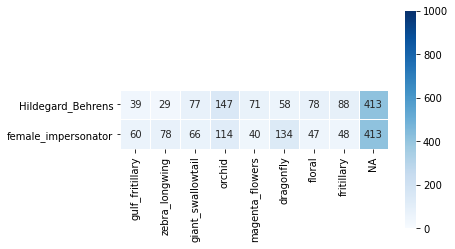

In [6]:
# %load analysis
from data_load import *
from common import identity_morphism
from graph_show import *
from my_function import *
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pygraphviz as pyg
import pprint
import math
from scipy.stats import pearsonr,spearmanr

# 連想強度をヒートマップで表示・出力する関数
def adj_matrix(source, target):

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    assoc_net = make_assoc_net(source = "source", target = "target")

    A_node_data = make_node_data(A,node_data)
    B_node_data = make_node_data(B,node_data)

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data:
            if assoc_net.has_edge(B_node,A_node):
                weight = assoc_net[B_node][A_node]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/nt_weight_"+target+"_"+source+".pdf",bbox_inches="tight")

    #同一コスライス圏の対象間でのコサイン類似度をヒートマップ出力
def adj_matrix_in_coslice(center):

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    assoc_net = make_assoc_net(source = "source", target = "target")

    center_node_data = make_node_data(center,node_data)

    matrix = list()
    for node1 in center_node_data:
        row = list()
        for node2 in center_node_data:
            if assoc_net.has_edge(node1,node2):
                weight = assoc_net[node1][node2]["weight"]
            else:
                weight = 0.0
            row.append(weight)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=center_node_data,columns=center_node_data)
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1.0,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True)
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/nt_weight_in_coslice_"+center+".pdf",bbox_inches="tight")


# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
def object_TINT_edge_correspondence_heatmap(target, source):
    Corr_DIR = "./object_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    weights = [0.05, 0.275, 0.5, 0.725, 0.95] # 0.05から0.225刻みの線形

    assoc_net = make_assoc_net(source="source",target="target")

    df_edge_corr = pd.read_csv(Corr_DIR+"Date_all_seed_6000_{}_{}_full_anti_1_iter_1000_correspondence.tsv".format(target,source),header=0,encoding="utf-8", sep="\t")
    df_edge_corr = df_edge_corr.fillna("NA")

    A_node_data =list(node_data[node_data[0] == target][1])
    A_node_data.remove(target)
    B_node_data = list(node_data[node_data[0] == source][1])
    B_node_data.remove(source)
    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}

    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[df_edge_corr["B_cod"]==B_node]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            row.append(edge_corr_dict[(B_node,A_node)])
        matrix.append(row)


    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True, fmt="d")
    plt.ylim(0,8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    # plt.savefig("nt_weight_"+A_name+"_"+B_name+".pdf")
    plt.savefig("./heatmap/object_edge_correspondence_count_"+target+"_"+source+".pdf")
    # plt.savefig("word2vec_edge_corr_count_"+A_name+"_"+B_name+".png")

# 記録した関手Fからどの対象がどの対象と対応づきやすいかをヒートマップで表示・出力する
def tri_TINT_edge_correspondence_heatmap(target, source,tri_dom, tri_cod):
    Corr_DIR = "./tri_edge_correspondence/"

    #全てのイメージのデータを取得する
    node_data = get_node_data()

    is_fill_graph = False

    df_edge_corr = pd.read_csv(Corr_DIR+"FOREDGE_Date_all_seed_6000_{}_{}_{}_{}_forced_anti_1_iter_1000_correspondence.tsv".format(target,source,tri_dom,tri_cod),header=0,encoding="utf-8", sep="\t")

    df_edge_corr = df_edge_corr.fillna("NA")
    A_node_data = make_node_data(target, node_data)
    if is_fill_graph:
        B_node_data = make_node_data(source, node_data)
    else:
        B_node_data = [tri_dom,tri_cod]

    edge_corr_dict = {(B_node,A_node):0 for A_node in A_node_data for B_node in B_node_data}
    for B_node in B_node_data:
        corr_A_nodes = df_edge_corr[(df_edge_corr["B_cod"]==B_node) & (df_edge_corr["B_dom"] == source)]
        for corr_A in corr_A_nodes.itertuples():
            count = corr_A.count
            edge_corr_dict[(B_node,corr_A.A_cod)] = count

    matrix = list()
    for B_node in B_node_data:
        row = list()
        for A_node in A_node_data+["NA"]:
            if (B_node,A_node) in edge_corr_dict:
                count = edge_corr_dict[(B_node,A_node)]
            else:
                count = 0
            row.append(count)
        matrix.append(row)

    df = pd.DataFrame(matrix,index=B_node_data,columns=A_node_data+["NA"])
    plt.clf()
    sns.heatmap(df,vmin=0.0,vmax=1000,cmap="Blues",linewidths=1,cbar=True,xticklabels=True,yticklabels=True,annot=True,fmt="d",square=True)
    plt.ylim(0,len(B_node_data))
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.savefig("./heatmap/tri_edge_correspondence_count_{}_{}_{}_{}.pdf".format(target,source,tri_dom,tri_cod),bbox_inches="tight")



if __name__ == "__main__":
    # 連想確率、TINTのシミュレーション結果(対象同士、三角構造同士)、人間の比喩解釈データをヒートマップで出力する
    A = "butterfly"
    B = "dancer"
    adj_matrix(A,B)
    adj_matrix_in_coslice(A)
    adj_matrix_in_coslice(B)
    object_TINT_edge_correspondence_heatmap(A,B)
    node_data = get_node_data()
    B_node_data = list(node_data[node_data[0] == B][1])
    B_node_data.remove(B)
    for dom, cod in iter.permutations(B_node_data,2):
        tri_TINT_edge_correspondence_heatmap(A,B,dom,cod)
